In [0]:
#参考”arxivの情報を使って特定分野の共著者ネットワークを書く”, Qiita 
#https://qiita.com/ek_ss/items/726319e2427202357fc4
#Cond-matから対象年度の論文情報をcsv形式で取得する
#データを取得済みの場合は次のセルから開始する
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import numpy as np
import math 

def month_string_to_number(string):
    m = {
        'jan': 1,
        'feb': 2,
        'mar': 3,
        'apr':4,
         'may':5,
         'jun':6,
         'jul':7,
         'aug':8,
         'sep':9,
         'oct':10,
         'nov':11,
         'dec':12
        }
    s = string.strip()[:3].lower()

    try:
        out = m[s]
        return out
    except:
        raise ValueError('Not a month')

# Search result のページから検索結果件数を取得
def get_number_of_searchresult(url):
    html_doc = requests.get(url).text
    soup = BeautifulSoup(html_doc, "html.parser") 
    tags = soup.find_all("h1",{"class":"title is-clearfix"})
    text = tags[0].text.strip()
    if "Showing" in text and "results" in text:
        stext = text.split(" ")
        datanum = int(stext[3].replace(',', ''))#検索結果の件数を取得
    else:
        datanum=math.nan
    return datanum

# Search resultsから情報取得しnp.ndarray化
def collect_info_from_advancedsearch(urlhead, datanum,key):

    titles=[]# データ保存用リスト
    absts=[]#Abst
    cites=[]# cite情報 (arxiv:XXXXXX)
    authors=[]# author
    dates=[]# 日付情報
    dates_orig_m =[]#初回投稿月
    dates_orig_y =[]#初回投稿年
    dois = []#doi
    fields=[]#cross-listを含む分野情報

    startnum=0
    while datanum > startnum:
        print(str(startnum)+"...", end="")
        url = urlhead+str(startnum)#advanced searchのURL 
        html_doc = requests.get(url).text
        soup = BeautifulSoup(html_doc, "html.parser") 

        # title情報
        tags1= soup.find_all("p", {"class": "title is-5 mathjax"}) 
        titles_tmp = [tag.text.strip() for tag in tags1]

        # abst情報
        tags2 = soup.find_all("span", {"class": "abstract-full has-text-grey-dark mathjax"})
        absts_tmp = [tag.text[:-7].strip() for tag in tags2 if "Less" in tag.text]

        # cite情報
        tags3 =soup.find_all("p", {"class": "list-title is-inline-block"})
        cites_tmp = [tag.select("a")[0].text for tag in tags3]

        # Date情報
        tags4 = soup.find_all("p",{"class":"is-size-7"})
        text = [tag.text.strip() for tag in tags4 if "originally announced" in tag.text ]
        dates_tmp = text
        dates_orig_y_tmp=[txt.split(" ")[-1][:-1] for txt in text]
        dates_orig_m_tmp=[month_string_to_number(txt.split(" ")[-2]) for txt in text]

        # DOI情報
        tags5 = soup.find_all("div",{"class":"is-marginless"})
        dois_tmp = [tag.text[tag.text.rfind("doi"):].split("\n")[1] for tag in tags5 if key in tag.text ]   

        # Author情報
        tags6= soup.find_all("p", {"class": "authors"}) 
        auths_tmp = []
        for tag in tags6:
            auths=tag.select("a")
            authlist=[(author.text,author.get("href")[33:]) for author in auths]
            auths_tmp.append(authlist)

        # Cross-list情報
        tags7= soup.find_all("div", {"class": "tags is-inline-block"})  # title#("span", {"class": "tag is-small is-link tooltip is-tooltip-top"})  # title
        fields_tmp=[tag.text.strip().split("\n") for tag in tags7]

        # 結果に追加
        titles.extend(titles_tmp)
        absts.extend(absts_tmp)
        cites.extend(cites_tmp)
        authors.extend(auths_tmp)
        dates.extend(dates_tmp)
        dates_orig_y.extend(dates_orig_y_tmp)
        dates_orig_m.extend(dates_orig_m_tmp)
        dois.extend(dois_tmp)
        fields.extend(fields_tmp)

        # 検索結果の次ページの開始番号更新
        startnum += sizenum

    nt = np.array(titles)
    na = np.array(absts)
    nauth = np.array(authors)
    ncite = np.array(cites)
    nd = np.array(dates)
    ndy = np.array(dates_orig_y)
    ndm = np.array(dates_orig_m)
    ndoi = np.array(dois)
    nfields=np.array(fields)
    npdataset = np.concatenate([[ncite],[nt],[na],[nauth],[nfields],[ndoi],[ndy],[ndm],[nd]],axis=0).T
    print(" collected data number : ", npdataset.shape[0])
    return npdataset

#検索クエリの検索対象分類の指定用辞書
dict_class={'cs': '&classification-computer_science=y',
 'econ': '&classification-economics=y',
 'eess': '&classification-eess=y',
 'math': '&classification-mathematics=y',
 'q-bio': '&classification-q_biology=y',
 'q-fin': '&classification-q_finance=y',
 'stat': '&classification-statistics=y',
 'all': '&classification-physics=y&classification-physics_archives=all',
 'astro-ph': '&classification-physics=y&classification-physics_archives=astro-ph',
 'cond-mat': '&classification-physics=y&classification-physics_archives=cond-mat',
 'gr-qc': '&classification-physics=y&classification-physics_archives=gr-qc',
 'hep-ex': '&classification-physics=y&classification-physics_archives=hep-ex',
 'hep-lat': '&classification-physics=y&classification-physics_archives=hep-lat',
 'hep-ph': '&classification-physics=y&classification-physics_archives=hep-ph',
 'hep-th': '&classification-physics=y&classification-physics_archives=hep-th',
 'math-ph': '&classification-physics=y&classification-physics_archives=math-ph',
 'nlin': '&classification-physics=y&classification-physics_archives=nlin',
 'nucl-ex': '&classification-physics=y&classification-physics_archives=nucl-ex',
 'nucl-th': '&classification-physics=y&classification-physics_archives=nucl-th',
 'physics': '&classification-physics=y&classification-physics_archives=physics',
 'quant-ph': '&classification-physics=y&classification-physics_archives=quant-ph'}

years = [y for y in range(2015,2016)]
key = 'cond-mat'#検索対象の分野　dict_classのkeyを指定
output_fname="df_cond-mat" #出力ファイル名

url0="https://arxiv.org/search/advanced?advanced=&terms-0-operator=AND&terms-0-term=&terms-0-field=title"
url1="&classification-include_cross_list=include"
url_daterange="&date-year=&date-filter_by=date_range"
url2="&date-date_type=submitted_date&abstracts=show&size="
urlmid = "&order=-announced_date_first&start="

sizenum = 25
startnum=0
for year in years:
    m_divide = 1 # 検索期間の分割数
    mstart =1
    mstop = 1
    url_date = "&date-from_date="+str(year)+"-"+str(mstart).zfill(2)+"-01&date-to_date="+str(year+1)+"-"+str(mstop).zfill(2)+"-01"
    urlhead = url0+dict_class[key]+url1+url_daterange+url_date+url2
    urlmid = "&order=-announced_date_first&start="
    url = urlhead+str(sizenum)+urlmid+str(startnum)

    datanum=get_number_of_searchresult(url) #検索結果件数の取得
    print("Number of search results ("+str(year)+") : "+str(datanum))

    if datanum >=10000: #件数がLimitを超えた場合、1年間のデータ取得を月ごとに分割
        m_divide = 13
        for month_divide in range(2,12): #個別件数がLimit以下になる分割数の探索
            flag_numlimit = False
            for idx in range(month_divide):
                mstart = int(idx*12/month_divide+1)
                mstop = (int((idx+1)*12/month_divide)+1)%12
                if mstop !=1:
                    url_date = "&date-from_date="+str(year)+"-"+str(mstart).zfill(2)+"-01&date-to_date="+str(year)+"-"+str(mstop).zfill(2)+"-01"
                else:
                    url_date = "&date-from_date="+str(year)+"-"+str(mstart).zfill(2)+"-01&date-to_date="+str(year+1)+"-"+str(mstop).zfill(2)+"-01"

                urlhead = url0+dict_class[key]+url1+url_daterange+url_date+url2
                url = urlhead+str(sizenum)+urlmid+str(startnum)
                datanum=get_number_of_searchresult(url)#分割数ごとでのデータ件数取得
                if datanum >= 10000:
                    flag_numlimit = True
            if not flag_numlimit:
                m_divide = month_divide
                break
        if m_divide > 12:
            print("*** Number of search result is over the limit 10,000. Please refine your search. ***")

    sizenum=200
    npdataset = np.empty((0,9))
    for idx in range(m_divide):
        mstart = int(idx*12/m_divide+1)
        mstop = (int((idx+1)*12/m_divide)+1)%12
        if mstop !=1:
            url_date = "&date-from_date="+str(year)+"-"+str(mstart).zfill(2)+"-01&date-to_date="+str(year)+"-"+str(mstop).zfill(2)+"-01"
        else:
            url_date = "&date-from_date="+str(year)+"-"+str(mstart).zfill(2)+"-01&date-to_date="+str(year+1)+"-"+str(mstop).zfill(2)+"-01"

        urlhead = url0+dict_class[key]+url1+url_daterange+url_date+url2       
        url = urlhead+str(25)+urlmid+str(0)
        datanum=get_number_of_searchresult(url)

        print("Collect search results ..." + url_date + ", Number of search results : " + str(datanum))
        urlhead2 = urlhead+str(sizenum)+urlmid
        npdataset_tmp = collect_info_from_advancedsearch(urlhead2,datanum,key)
        npdataset = np.concatenate([npdataset, npdataset_tmp], axis=0)

    #1年分の情報をnumpy、pandas DataFrameに変換してcsvに保存
    dataset = pd.DataFrame(npdataset)
    dataset.columns =["Cite","Title","Abst","Authors","Fields","DOI", "OrigDateY","OrigDateM","Date Info"]
    dataset.to_csv(output_fname+str(year)+".csv")


Number of search results (2015) : 16612
Collect search results ...&date-from_date=2015-01-01&date-to_date=2015-07-01, Number of search results : 8121
0...200...400...600...800...1000...1200...1400...1600...1800...2000...2200...2400...2600...2800...3000...3200...3400...3600...3800...4000...4200...4400...4600...4800...5000...5200...5400...5600...5800...6000...6200...6400...6600...6800...7000...7200...7400...7600...7800...8000... collected data number :  8121
Collect search results ...&date-from_date=2015-07-01&date-to_date=2016-01-01, Number of search results : 8491
0...200...400...600...800...1000...1200...1400...1600...1800...2000...2200...2400...2600...2800...3000...3200...3400...3600...3800...4000...4200...4400...4600...4800...5000...5200...5400...5600...5800...6000...6200...6400...6600...6800...7000...7200...7400...7600...7800...8000...8200...8400... collected data number :  8491


In [0]:
#https://qiita.com/ek_ss/items/726319e2427202357fc4
#必要な年度のデータがcsv形式で保存されている場合はこのセルから開始する。
#必要なライブラリのimport
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math 

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

import networkx as nx
import collections

import itertools

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
#テキストデータの処理
def preprocess_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)#Remove punctuations
    text = text.lower()
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)#remove tags
    text=re.sub("(\\d|\\W)+"," ",text)# remove special characters and digits

    text = text.split()

    stop_words = set(stopwords.words("english"))
    ##Stemming
    #Lemmatisation
    ps=PorterStemmer()
    #lem = WordNetLemmatizer()
    text = [ps.stem(word) for word in text if not word in stop_words]
    text=" ".join(text)

    return text



In [0]:
#処理する複数年度のcsvデータを結合して一つのデータとする。
fname_head = "df_cond-mat"

fname ="/content/"+ fname_head + str(2019)+".csv"
dataset = pd.read_csv(fname, index_col=0)

for year in range(2015,2019):
    fname = "/content/" + fname_head + str(year)+".csv"
    print(fname)
    dataset_tmp = pd.read_csv(fname, index_col=0)
    dataset = pd.concat([dataset,dataset_tmp])

ndata = (dataset['Title']+" "+ dataset['Abst']).values
ndata= np.array([preprocess_text(text) for text in ndata])
dataset['Keywords'] = ndata
dataset =dataset.reset_index()


/content/df_cond-mat2015.csv
/content/df_cond-mat2016.csv
/content/df_cond-mat2017.csv
/content/df_cond-mat2018.csv


In [0]:
#検索するキーワードの設定。アブストラクトとタイトルにキーワードが含まれる論文を抽出する。複数キーワードにも拡張可能なはず。
word="topolo"
dataset_r=dataset[dataset['Keywords'].str.contains(word)]

In [0]:
print(dataset_r.head()) #冒頭５つの情報
print(dataset_r.shape) #抽出した単語の論文数
print(dataset.shape) #全論文数

    index  ...                                           Keywords
9       9  ...  anderson orthogon catastroph topolog system th...
20     20  ...  possibl topolog phase transit fe vacanc order ...
24     24  ...  realiz order magnet skyrmion thin film ambient...
35     35  ...  quantum anomal hall phase topolog metal intera...
42     42  ...  two dimension honeycomb borophen oxid promis a...

[5 rows x 11 columns]
(11359, 11)
(90705, 11)


In [0]:
#抽出した論文に含まれる各著者とその論文数を抽出する
%%time

auths= dataset_r['Authors'].values
datanum = auths.shape[0]

auth_dict = {} 
pattern = re.compile(r"(\()(.*?)\)")
for idx in range(datanum):
    match = re.findall(pattern,auths[idx])
    for m in match:
        auth = m[1].split(m[1][-1])[-2]
        authname = m[1].split(m[1][0])[1]
        auth_dict.setdefault(auth,[])
        auth_dict[auth].append(authname)

#論文数有りの場合
for key,value in auth_dict.items():
    count = collections.Counter(value)
    auth_dict[key]=(count.most_common()[0][0],len(value))

print(auth_dict)



{'Gu%2C+J': ('Jiahua Gu', 3), 'Yeh%2C+K': ('Keng-Yu Yeh', 1), 'Lo%2C+T': ('Tung-Sheng Lo', 1), 'Chang%2C+C': ('Cui-Zu Chang', 43), 'Wu%2C+P': ('Phillip Wu', 3), 'Chang-Liao%2C+K': ('Kuei-Shu Chang-Liao', 1), 'Wang%2C+M': ('Meng Wang', 26), 'Wu%2C+M': ('Mingzhong Wu', 11), 'Desautels%2C+R+D': ('Ryan D. Desautels', 2), 'DeBeer-Schmitt%2C+L': ('L. DeBeer-Schmitt', 5), 'Montoya%2C+S': ('Sergio Montoya', 1), 'Borchers%2C+J+A': ('Julie A. Borchers', 4), 'Je%2C+S': ('Soong-Geun Je', 4), 'Tang%2C+N': ('Nan Tang', 1), 'Im%2C+M': ('Mi-Young Im', 5), 'Fitzsimmons%2C+M+R': ('Michael R. Fitzsimmons', 1), 'Fullerton%2C+E+E': ('Eric E. Fullerton', 6), 'Gilbert%2C+D+A': ('Dustin A. Gilbert', 3), 'Lopez%2C+M+F': ('Manuel Fernandez Lopez', 1), 'Merino%2C+J': ('J. Merino', 7), 'Hu%2C+J': ('Jiangping Hu', 52), 'Zhong%2C+C': ('Chengyong Zhong', 10), 'Wu%2C+W': ('Weida Wu', 35), 'Liu%2C+N': ('Ning Liu', 3), 'Liu%2C+Y': ('Ying Liu', 111), 'Yang%2C+S+A': ('Shengyuan A. Yang', 36), 'Ouyang%2C+C': ('Chuying Ouy

In [0]:
#グラフに情報追加
G=nx.DiGraph()
for idx in range(datanum):
    match = re.findall(pattern,auths[idx])
    for m in match:
        auth = m[1].split(m[1][-1])[-2]
        #authname = m[1].split(m[1][0])[1]#表記のままでグラフ作成したい場合はこのauthnameで辺を追加する
        G.add_edges_from([(idx,auth_dict[auth][0])])
        #G.add_edges_from([(idx,auth_dict[authname])])

In [0]:
#著者のArxiv表記とフルネーム、論文数をcsvとして保存する
dict_pd=pd.DataFrame(auth_dict)
dict_pd=dict_pd.T
dict_pd.columns=["authername", "paper"]
dict_pd["paper"]=dict_pd["paper"].astype(int)
dict_pd=dict_pd.sort_values(by="paper",ascending=False)
print(dict_pd)
dict_pd.to_csv("dictionary_"+word+".csv", encoding="utf_8")

                          authername  paper
Wang%2C+Z                Zhijun Wang    201
Wang%2C+Y                  Yayu Wang    161
Wang%2C+J                  Jing Wang    150
Zhang%2C+S          Shou-Cheng Zhang    137
Zhang%2C+Y                  Yi Zhang    122
...                              ...    ...
Berthier%2C+C            C. Berthier      1
Horvati%C4%87%2C+M       M. Horvatić      1
Strzelecka%2C+S        S. Strzelecka      1
Szirmai%2C+E           Edina Szirmai      1
Pi%C4%85tek%2C+M       Marcin Piątek      1

[17580 rows x 2 columns]


In [0]:
#共同研究者ネットワークの作成。全員ふくめるとネットワークが混雑するので、エッジ数(共同研究者数)の閾値を設定する
thr=80 #繋がり数thr未満の人は削除、
authorlist = [n  for n in G.nodes() if type(n) is str]
G_removed=G.copy()
for auth in authorlist:
    deg=G_removed.degree(auth)
    if deg <=thr:
        G_removed.remove_node(auth)

#上記の結果、次数がゼロになった著者を削除。その人とつながっていた人分人数減
for idx in range(datanum):
    deg=G_removed.degree(idx)
    if deg <=0:
        G_removed.remove_node(idx)

In [0]:
#ネットワークの作成
def draw_graph(G, label = False):
    # pagerank の計算
    pr = nx.pagerank(G)
    pos = nx.spring_layout(G)

    fig = plt.figure(figsize=(8.0, 6.0))
    c=[(0.4,0.4,1) if type(n) is str else (1,0.4,0.4)  for n in G.nodes()]

    nx.draw_networkx_edges(G,pos, edge_color=(0.3,0.3,0.3))
    nx.draw_networkx_nodes(G,pos, node_color=c, node_size=[5000*v for v in pr.values()])

In [0]:
#ネットワークのエッジに共同研究数の重みをつける
def convert_weightedGraph(graph):
    graph_new =nx.Graph()
    for node in graph.nodes:
        if type(node) is str:
            continue
        n_new = [e[1] for e in graph.edges if e[0]==node]
        for e_new in itertools.permutations(n_new, 2):

            flag_dup = False
            for e_check in graph_new.edges(data=True):
                if e_new[0] in e_check and e_new[1] in e_check:
                    e_check[2]['weight']+=1
                    flag_dup = True
            if not flag_dup:
                graph_new.add_edge(e_new[0],e_new[1],weight=1)
    return graph_new

wG=convert_weightedGraph(G_removed)

In [0]:
#完成したネットワーク上の研究者名とエッジ数をcsvで保存する。
record=pd.DataFrame(wG.degree, columns=['Author', 'Edge'])
record=record.sort_values(by='Edge',ascending=False)
print(record.head())
record.to_csv("wEdge_"+word+".csv")


                  Author  Edge
3       Karen E. Daniels     7
1    Robert P. Behringer     6
0               Hu Zheng     4
5   Francisco Vega Reyes     4
11            Jindong Li     4


In [0]:
#ネットーワークを図にする
def draw_weightedG(G):
    fig = plt.figure(figsize=(8.0, 6.0))
    pr = nx.pagerank(G)
    k0=20 #ノード間距離の調節数値
    pos = nx.fruchterman_reingold_layout(G,k=k0/math.sqrt(G.order()))
    #pos = nx.spring_layout(G,k=15/math.sqrt(G.order())) 
    #適当なlayoutを使う。kの値でノード間距離を微調整  


    x_values, y_values = zip(*pos.values())
    x_max = max(x_values)
    x_min = min(x_values)
    x_margin = (x_max - x_min) * 0.25
    plt.xlim(x_min - x_margin, x_max + x_margin) #ラベル文字が切れないようにマージン確保

    node_sizes=[5000*v for v in pr.values()]
    edge_colors = [e[2]['weight'] for e in G.edges(data=True)] #辺の重みで色付け
    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='#9999ff')
    edges = nx.draw_networkx_edges(G, pos, node_size=node_sizes, arrowstyle='->',
                                   arrowsize=10, edge_color=edge_colors,
                                   edge_cmap=plt.cm.Blues, width=2)
    nx.draw_networkx_labels(G,pos)

    ax = plt.gca()
    ax.set_axis_off()

In [0]:
#ネットワーク上の研究者名とエッジ数のリスト
print(list(G.edges))

[(0, 'Christopher McMahon'), (0, 'A. J. Achkar'), (0, 'E. H. da Silva Neto'), (0, 'I. Djianto'), (0, 'J. Menard'), (0, 'F. He'), (0, 'R. Sutarto'), (0, 'R. Comin'), (0, 'R. Liang'), (0, 'D. A. Bonn'), (0, 'W. N. Hardy'), (0, 'A. Damascelli'), (0, 'D. G. Hawthorn'), (1, 'Yuxuan Wang'), (1, 'Yong Zhong'), (1, 'Zhiling Luo'), (1, 'Menghan Liao'), (1, 'Ruifeng Wang'), (1, 'Ziyuan Dou'), (1, 'Qinghua Zhang'), (1, 'Ding Zhang'), (1, 'Lin Gu'), (1, 'Can-Li Song'), (1, 'Xu-Cun Ma'), (1, 'Qi-Kun Xue'), (2, 'Andrey A. Bagrov'), (2, 'Mikhail Danilov'), (2, 'Sergey Brener'), (2, 'Malte Harland'), (2, 'Alexander I. Lichtenstein'), (2, 'M. I. Katsnelson'), (3, 'J. P. F. LeBlanc'), (3, 'Shiliang Li'), (3, 'X. H. Chen'), (3, 'Ryan Levy'), (3, 'A. E. Antipov'), (3, 'Andrew J. Millis'), (3, 'Emanuel Gull'), (4, 'J. M. Tranquada'), (5, 'J. E. Hirsch'), (5, 'F. Marsiglio'), (6, 'Hiroaki Niwa'), (6, 'Naotaka Yoshikawa'), (6, 'Kaito Tomari'), (6, 'Ryusuke Matsunaga'), (6, 'Dongjoon Song'), (6, 'H. Eisaki'),

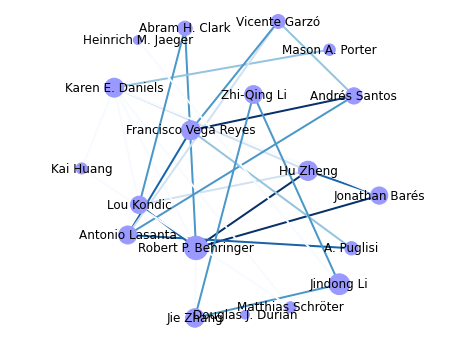

In [0]:
#図にする
draw_weightedG(wG)
plt.show()

In [0]:
#連結かどうかで部分グラフに分割する
def add_edges_to_wsubgraph(subg, edge_new,node,edges_all):
    subg.add_edges_from([edge_new])

    if node == edge_new[1]:
        node_new = edge_new[0]
    else:
        node_new = edge_new[1]

    edges_new = [e for e in edges_all if node_new in e and e not in subg.edges(data=True)]
    for edge in edges_new:
        if edge not in subg.edges(data=True):
            add_edges_to_wsubgraph(subg,edge,node_new,edges_all)

def separate_wG_by_connectivity(G):
    nodes_all =[n for n in G.nodes()]
    edges_all = [e for e in G.edges(data=True)]
    subgraphs = []

    for node in nodes_all:
        usedflag = any([node in g.nodes for g in subgraphs])
        if usedflag:
            continue 

        subg = nx.Graph()
        subg.add_node(node)
        edges_new = [e for e in edges_all if node in e]
        for edge in edges_new:
            if edge not in subg.edges(data=True):
                add_edges_to_wsubgraph(subg,edge,node,edges_all)
        subgraphs.append(subg)

    return subgraphs

subgraphs = separate_wG_by_connectivity(wG)

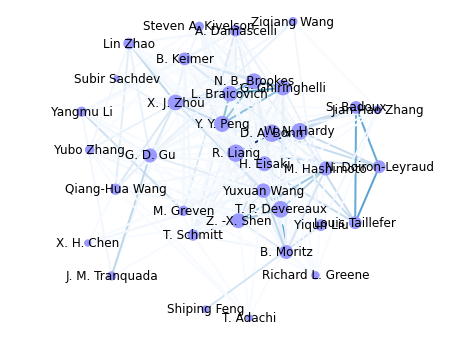

In [0]:
#図にする

draw_weightedG(subgraphs[0])

plt.show()

# 新しいセクション